In [128]:
import numpy as np
import pandas as pd
import re
import krippendorff
from statsmodels.stats.inter_rater import fleiss_kappa
from collections import defaultdict, Counter
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

In [299]:
#Fetching Data

df_mikkel = pd.read_json("annotations_mikkel.json")
df_david = pd.read_json("annotations_david.json")
df_carl = pd.read_json("annotations_carl.json")

#Fix of dataframe
def parse_label_string(label_str):
    return re.findall(r"'(.*?)'", label_str)

df_mikkel['original_label'] = df_mikkel['original_label'].apply(parse_label_string)

#Check:
df_mikkel["original_label"].iloc[0][0]

'None'

In [300]:
# Preparing data and setting variables 

num_encoder = {'None': 0,
               'Minimal': 1,
               'Basic': 2,
               'Good': 3,
               'Excellent': 4,
               '❗ Problematic Content ❗': 0, # for security
            }

N = len(df_mikkel)
R = 5 #number of ratings

score_dict = {}
score_data = []

for i in range(len(df_mikkel)):
    labels = [df_carl["our_label"].iloc[i], df_mikkel["our_label"].iloc[i], df_david["our_label"].iloc[i]] + df_mikkel["original_label"].iloc[i]
    scores = [num_encoder[label] for label in labels]
    id_ = df_mikkel["id"].iloc[i]
    score_dict[id_] = scores #dict of lists
    score_data.append(scores) # list of lists

____

## Global aggreement: MSD and Krippendorffs $\alpha$

### MSD

In [248]:

def Mean_Squared_Diff(score_data): # <-- list of lists

    SD_list = []

    for scores in score_data:
        c = len(scores)
        #The Squared Difference between unordered distinct pairs for one text:
        SD = (2 / (c * (c - 1))) * sum(
            (scores[j] - scores[k]) ** 2 
            for j in range(c) 
            for k in range(j+1,c))
        SD_list.append(SD)

    return np.mean(SD_list)

MSD = np.mean(Mean_Squared_Diff(score_data))

MSD

np.float64(1.2646666666666666)

### Krippendorff's $\alpha$

In [249]:
# Alpha calculated with library
def K_alpha(score_data,datatype):
    reliability_data = np.array(score_data).T 
    alpha = krippendorff.alpha(reliability_data=reliability_data, value_domain=list(range(R)), level_of_measurement=datatype)
    return alpha

alpha = K_alpha(score_data,"interval")
alpha

np.float64(0.4401220957303449)

In [247]:
#Alpha calculated by hand assuming equal intervals:

D_o = MSD

# All annotation scores
all_scores = np.asarray(score_data).flatten()


label_counts = Counter(all_scores)  #dict
labels = list(range(R))
n_total = len(all_scores)  # total annotations

# Calculate D_e
De_numerator = 0
for i in range(R):
    for j in range(i + 1, R):
        a = labels[i]
        b = labels[j]
        n_a = label_counts[a]
        n_b = label_counts[b]
        delta = (a - b) ** 2
        De_numerator += n_a * n_b * delta

D_e =  De_numerator * 2 / (n_total * (n_total - 1))

alpha_simplifed = 1 - D_o / D_e
alpha_simplifed

np.float64(0.4401220957303449)

In [ ]:
#Comparing to ordinal delta function
alpha_ordinal = K_alpha(score_data, "ordinal")
diff_alpha = alpha - alpha_ordinal

print(f"alpha (interval): {alpha}")
print(f"alpha (ordinal): {alpha_ordinal}")
print(f"Difference (alpha - alpha_ordinal): {diff_alpha}")

alpha (interval): 0.4401220957303449
alpha (ordinal): 0.44388382293447715
Difference (alpha - alpha_ordinal): -0.003761727204132259


_______
## Comparing annotator-groups

In [302]:
n = 3 #number of author annotators

data = {"author": [scores[:n] for scores in score_data],
        "fineweb": [scores[n:] for scores in score_data],
        "all": score_data}

agreement = {}
for name,list_score in data.items():
    agreement[name] = (Mean_Squared_Diff(list_score), 
                       K_alpha(list_score, "ordinal"),
                       np.mean([np.mean(scores) for scores in list_score])
                       )
agreement

{'author': (np.float64(0.9666666666666666),
  np.float64(0.560818764498379),
  np.float64(1.106666666666667)),
 'fineweb': (np.float64(1.6066666666666665),
  np.float64(0.3381319866159098),
  np.float64(0.9500000000000002)),
 'all': (np.float64(1.2646666666666666),
  np.float64(0.44388382293447715),
  np.float64(1.0283333333333333))}

### Statistic tests

In [ ]:
# Normality for MSD
from scipy.stats import shapiro

# first we define the MSD function:
def Squared_diff_list(score_data): # <-- list of lists

    SD_list = []
    for scores in score_data:
        c = len(scores)
        #The Squared Difference between unordered distinct pairs for one text:
        SD = (2 / (c * (c - 1))) * sum(
            (scores[j] - scores[k]) ** 2 
            for j in range(c) 
            for k in range(j+1,c))
        SD_list.append(SD)

    return SD_list

# Shapiro Wilk
stat, p_aut = shapiro(Squared_diff_list(data["author"]))
print(f"Shapiro-Wilk p 'author' = {p_aut}")

stat, p_fine = shapiro(Squared_diff_list(data["fineweb"]))
print(f"Shapiro-Wilk p 'fineweb' = {p_fine}")

Shapiro-Wilk p 'author' = 5.730903158670814e-13
Shapiro-Wilk p 'fineweb' = 2.761921713048834e-10


In [319]:
def hist_dist(sample1, sample2, name1, name2, type):
    sns.set(style="whitegrid")
    
    bins = [0.5 * x - 0.5 for x in range(16)]

    if type == "msd":
        list1 = Squared_diff_list(sample1)
        list2 = Squared_diff_list(sample2)

    elif type == "mean":
        list1 = [np.mean(scores) for scores in sample1]
        if sample2[0] is float:
            list2 = sample2
        else:
            list2 = [np.mean(scores) for scores in sample2]
        

    # Plot
    plt.figure(figsize=(8, 5))
    plt.hist(list1, bins=bins, edgecolor='black', color='skyblue', alpha=0.5, label=name1, rwidth=0.9)
    plt.hist(list2, bins=bins, edgecolor='black', color='salmon', alpha=0.5, label=name2, rwidth=0.9)

    # Customize axes
    plt.xlabel(type.upper() + ' Values')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Clean layout
    plt.tight_layout()
    plt.show()

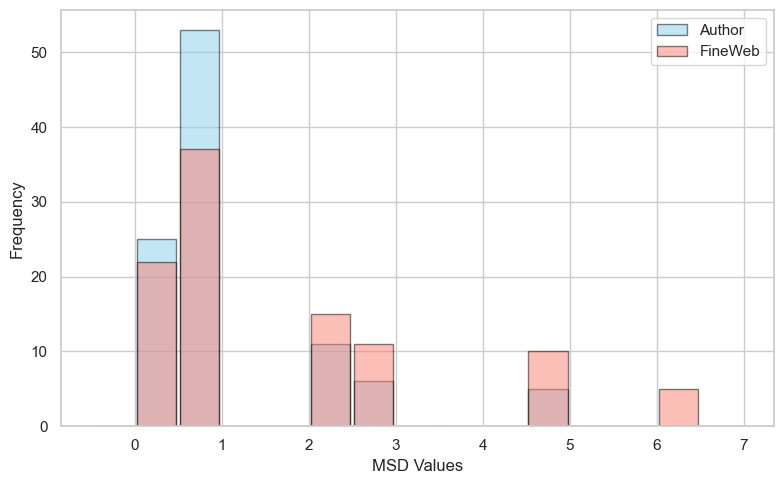

In [259]:
hist_dist(data["author"],data["fineweb"], "Author", "FineWeb", "msd")

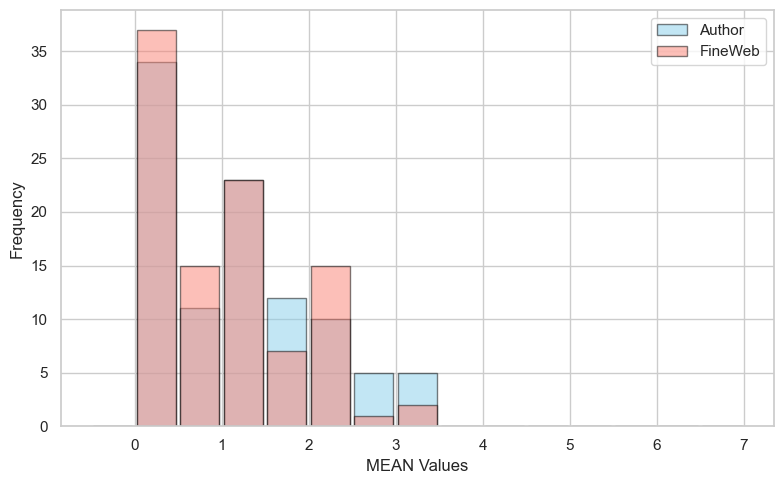

In [260]:
hist_dist(data["author"],data["fineweb"], "Author", "FineWeb", "mean")

In [ ]:
#paired non-parametric test MSD
from scipy.stats import wilcoxon

def wilcoxon_test(sample1, sample2 , type):
    if type == "msd":
        list1 = Squared_diff_list(sample1)
        list2 = Squared_diff_list(sample2)

    elif type == "mean":
        list1 = [np.mean(scores) for scores in sample1]
        if sample2[0] is float:
            list2 = sample2
        else:
            list2 = [np.mean(scores) for scores in sample2]
    else:
        "Error"
    #print(len(list1),len(list2))
    return wilcoxon(list1,list2) # returns --> wilcoxon_stat, wilcoxon_p$

In [306]:
# Paired test
wilcoxon_stat_msd, wilcoxon_p_msd = wilcoxon_test(data["author"], data["fineweb"], "msd")
wilcoxon_stat_mean, wilcoxon_p_mean = wilcoxon_test(data["author"], data["fineweb"], "mean")

print(f"Wilcoxon p-value (MSD): {wilcoxon_p_msd}")
print(f"Wilcoxon p-value (Mean): {wilcoxon_p_mean}")

Wilcoxon p-value (MSD): 0.0019335420818070834
Wilcoxon p-value (Mean): 0.024049874094710655


### Comparing our trained models

In [307]:
df_models = pd.read_json("../test/final_results.json", lines=True)

model_data = defaultdict(list)

raw_cols = [col for col in df_models.columns if col.startswith("raw")]
for col in raw_cols:
    model_data[col] = df_models[col].tolist()

In [314]:
for name, scores in model_data.items():
    wilcoxon_stat, wilcoxon_p = wilcoxon_test(data["all"], scores, "mean")
    shapiro_stat, shapiro_p = shapiro(scores)
    print(f"Model: {name}")
    print(f"Shapiro-Wilk p-value: {shapiro_p}")
    print(f"Wilcoxon p-value (Human Mean vs model): {wilcoxon_p}")
    print("")

Model: raw_prediction_zeroshot
Shapiro-Wilk p-value: 0.677019941373097
Wilcoxon p-value (Human Mean vs model): 0.0006157696889992708

Model: raw_prediction_Full-finetune
Shapiro-Wilk p-value: 0.35936400184304673
Wilcoxon p-value (Human Mean vs model): 0.045752803008419725

Model: raw_prediction_fewshot-250-samples
Shapiro-Wilk p-value: 0.6667966034322942
Wilcoxon p-value (Human Mean vs model): 7.459504884752048e-06

Model: raw_prediction_fewshot-1000-samples
Shapiro-Wilk p-value: 0.6708629002098552
Wilcoxon p-value (Human Mean vs model): 0.0003445208537720272

Model: raw_prediction_fewshot-2500-samples
Shapiro-Wilk p-value: 0.6578051998240472
Wilcoxon p-value (Human Mean vs model): 0.0001144119843118567



All models predicted significantly different scores than the human mean. (p-value > 0.05).

In [ ]:
for name, scores in model_data.items():
    data_model_and_all = [[scores[i]] + data["all"][i] for i in range(len(scores))] 
    wilcoxon_stat, wilcoxon_p = wilcoxon_test(score_data, data_model_and_all, "msd")
    MSD_score = Mean_Squared_Diff(data_model_and_all)
    print(f"Model {name}, MSD: {MSD_score}, Wilcoxon p-value: {wilcoxon_p}")

/opt/anaconda3/envs/FP25/lib/python3.11/site-packages/krippendorff/krippendorff.py:364: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - (o * d).sum() / (e * d).sum()


ValueError: The reliability data contains out-of-domain values.

All models significantly raise the inter-annotator disagreement (MSD) when added the human annotators (p-values > 0.05). The MSD before the models where added was 1.26.

___
## Comparing classes
We create pools for each annotation class, including all items where a specific class was annotated at least once.

In [ ]:
agreement_pools = {}
for i in range(R):
    pool = [scores for scores in data["all"] if i in scores]
    agreement_pools[i] = (Mean_Squared_Diff(pool), K_alpha(pool,"interval"), K_alpha(pool,"nominal"))
                        
    print(pool)

agreement_pools

[[0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 2], [2, 1, 0, 2, 0, 0], [1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 1, 0], [0, 0, 0, 1, 0, 1], [0, 1, 0, 0, 3, 0], [0, 2, 1, 2, 1, 3], [2, 2, 2, 0, 1, 3], [0, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 1], [0, 2, 0, 2, 0, 0], [0, 1, 0, 1, 0, 1], [3, 3, 2, 0, 0, 2], [0, 0, 0, 0, 0, 0], [2, 2, 1, 0, 1, 3], [1, 2, 0, 0, 0, 0], [2, 3, 1, 1, 0, 3], [4, 3, 2, 0, 0, 1], [0, 1, 0, 1, 0, 2], [0, 1, 0, 0, 0, 0], [1, 2, 0, 3, 2, 1], [0, 2, 3, 1, 1, 1], [0, 0, 0, 0, 0, 1], [3, 4, 1, 3, 2, 0], [0, 0, 0, 0, 0, 0], [0, 3, 1, 0, 1, 2], [0, 1, 0, 0, 1, 0], [2, 2, 0, 0, 1, 3], [0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 1], [0, 1, 0, 1, 0, 0], [1, 2, 2, 0, 3, 1], [1, 2, 1, 1, 3, 0], [0, 1, 1, 0, 0, 0], [0, 1, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0], [0, 1, 0, 1, 1, 0], [0, 0, 0, 0, 1, 0], [1, 1, 3, 1, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 1, 2, 1, 0, 2], [0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [1, 0, 1, 0, 1, 0], [1, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1], [1, 1, 1, 1, 0, 1], [1, 1, 1, 0, 0, 1],

{0: (np.float64(1.1981981981981982),
  np.float64(0.2003480792500809),
  np.float64(0.07934703347696381),
  np.float64(0.07726881007623465)),
 1: (np.float64(1.3450980392156862),
  np.float64(0.31841848653781846),
  np.float64(0.08497435840388046),
  np.float64(0.08317666559131401)),
 2: (np.float64(1.851190476190476),
  np.float64(0.2062311439435841),
  np.float64(0.009585953256614044),
  np.float64(0.006629493415589061)),
 3: (np.float64(2.25),
  np.float64(0.1029584860927929),
  np.float64(-0.03136084679916662),
  np.float64(-0.036157873993581384)),
 4: (np.float64(2.5380952380952375),
  np.float64(-0.016476265576985005),
  np.float64(-0.025458629726694104),
  np.float64(-0.037813552976413346))}

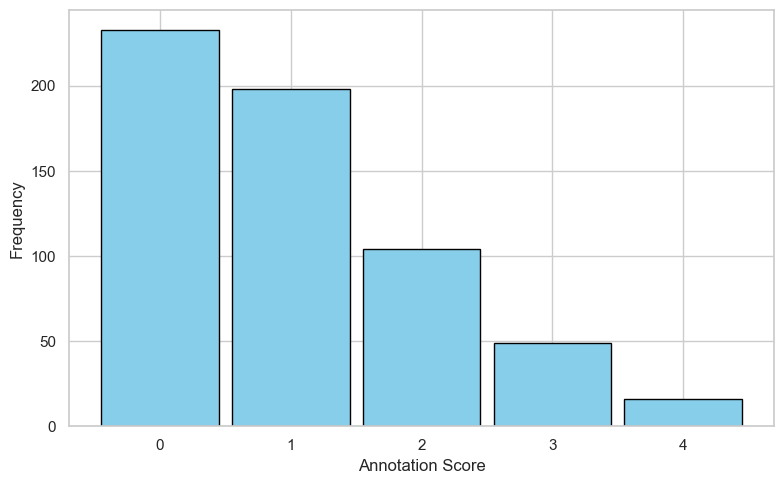

In [ ]:
sns.set(style="whitegrid")

bins = [x - 0.5 for x in range(6)]

# Plot
plt.figure(figsize=(8, 5))
plt.hist(all_scores, bins=bins, edgecolor='black', color='skyblue', rwidth=0.9,)

# Customize axes
plt.xticks(range(5)) 
plt.xlabel('Annotation Score')
plt.ylabel('Frequency')

# Clean layout
plt.tight_layout()
plt.show()